# CS 180 Project 5A

In this problem set you will play around with diffusion models, implement diffusion sampling loops, and use them for other tasks such as inpainting and creating optical illusions.

# Part 0: Setup

### Using DeepFloyd

We are going to use the [DeepFloyd IF](https://huggingface.co/docs/diffusers/api/pipelines/deepfloyd_if) diffusion model. DeepFloyd is a two stage model trained by Stability AI. The first stage produces images of size $64 \times 64$ and the second stage takes the outputs of the first stage and generates images of size $256 \times 256$. We provide upsampling code at the very end of the notebook, though this is not required in your submission.

Before using DeepFloyd, you must accept its usage conditions. To do so:

1. Make a [Hugging Face account](https://huggingface.co/join) and log in.
2. Accept the license on the model card of [DeepFloyd/IF-I-XL-v1.0](https://huggingface.co/DeepFloyd/IF-I-XL-v1.0). For affiliation, you can fill in "The University of California, Berkeley." Accepting the license on the stage I model card will auto accept for the other IF models.
3. Log in locally by entering your [Hugging Face Hub access token](https://huggingface.co/docs/hub/security-tokens#what-are-user-access-tokens) below. You should be able to find and create tokens [here](https://huggingface.co/settings/tokens). A read token is enough for this project.

In [ ]:
from huggingface_hub import login

login(token=token)

### Install Dependencies

Run the below to install dependencies.

In [2]:
! pip install -q \
  diffusers \
  transformers \
  safetensors \
  sentencepiece \
  accelerate \
  bitsandbytes \
  einops \
  mediapy \
  accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 38.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 76.5 MB/s eta 0:00:00


### Import Dependencies

The cell below imports useful packages we will need, and setup the device that we're using.

In [3]:
from PIL import Image
import mediapy as media
from pprint import pprint
from tqdm import tqdm
import numpy as np

import torch
import torchvision.transforms.functional as TF
import torchvision.transforms as transforms
from diffusers import DiffusionPipeline
from transformers import T5EncoderModel

# For downloading web images
import requests
from io import BytesIO

device = 'cuda'

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Loading the models

We will need to download and create the two DeepFloyd stages. These models are quite large, so this cell may take a minute or two to run.

In [4]:
# Load DeepFloyd IF stage I
stage_1 = DiffusionPipeline.from_pretrained(
    "DeepFloyd/IF-I-L-v1.0",
    text_encoder=None,
    variant="fp16",
    torch_dtype=torch.float16,
)
stage_1.to(device)

# Load DeepFloyd IF stage II
stage_2 = DiffusionPipeline.from_pretrained(
                "DeepFloyd/IF-II-L-v1.0",
                text_encoder=None,
                variant="fp16",
                torch_dtype=torch.float16,
              )
stage_2.to(device)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/604 [00:00<?, ?B/s]


A mixture of fp16 and non-fp16 filenames will be loaded.
Loaded fp16 filenames:
[text_encoder/model.fp16-00002-of-00002.safetensors, text_encoder/model.fp16-00001-of-00002.safetensors, safety_checker/model.fp16.safetensors, unet/diffusion_pytorch_model.fp16.safetensors, text_encoder/model.safetensors.index.fp16.json, text_encoder/pytorch_model.bin.index.fp16.json]
Loaded non-fp16 filenames:
[watermarker/diffusion_pytorch_model.safetensors
If this behavior is not expected, please check your folder structure.


Fetching 12 files:   0%|          | 0/12 [00:00<?, ?it/s]

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

tokenizer/spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.63k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/518 [00:00<?, ?B/s]

safety_checker/model.fp16.safetensors:   0%|          | 0.00/608M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.57k [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/454 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.fp16.safete(…):   0%|          | 0.00/1.87G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/74.0 [00:00<?, ?B/s]

watermarker/diffusion_pytorch_model.safe(…):   0%|          | 0.00/15.5k [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

`torch_dtype` is deprecated! Use `dtype` instead!
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


model_index.json:   0%|          | 0.00/692 [00:00<?, ?B/s]


A mixture of fp16 and non-fp16 filenames will be loaded.
Loaded fp16 filenames:
[text_encoder/model.fp16-00002-of-00002.safetensors, text_encoder/model.fp16-00001-of-00002.safetensors, safety_checker/model.fp16.safetensors, unet/diffusion_pytorch_model.fp16.safetensors, text_encoder/model.safetensors.index.fp16.json, text_encoder/pytorch_model.bin.index.fp16.json]
Loaded non-fp16 filenames:
[watermarker/diffusion_pytorch_model.safetensors
If this behavior is not expected, please check your folder structure.


Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

scheduler_config.json:   0%|          | 0.00/424 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.92k [00:00<?, ?B/s]

tokenizer/spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

safety_checker/model.fp16.safetensors:   0%|          | 0.00/608M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/518 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/454 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.50k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

watermarker/diffusion_pytorch_model.safe(…):   0%|          | 0.00/15.5k [00:00<?, ?B/s]

unet/diffusion_pytorch_model.fp16.safete(…):   0%|          | 0.00/2.49G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.72k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/74.0 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

IFSuperResolutionPipeline {
  "_class_name": "IFSuperResolutionPipeline",
  "_diffusers_version": "0.35.2",
  "_name_or_path": "DeepFloyd/IF-II-L-v1.0",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "image_noising_scheduler": [
    "diffusers",
    "DDPMScheduler"
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    "deepfloyd_if",
    "IFSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "DDPMScheduler"
  ],
  "text_encoder": [
    null,
    null
  ],
  "tokenizer": [
    "transformers",
    "T5Tokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "watermarker": [
    "deepfloyd_if",
    "IFWatermarker"
  ]
}

### Play with the Model using Your Own Text Prompts!

DeepFloyd was trained as a text-to-image model, which takes text prompts as input and outputs images that are aligned with the text. However, a raw text string cannot be directly used as the model's input — we first need to convert it into a high-dimensional vector (of 4096 dimensions in our case) that the model can understand, a.k.a. prompt embeddings.

Since prompt encoders are always very big and hard to run in your notebook, we provide two  Huggingface clusters [A](https://huggingface.co/spaces/jamesoncrate/CS180-T5-Encoder) and [B](https://huggingface.co/spaces/konpat/CS180-T5-Encoder) for generating your own prompt embeddings! Both are the same and feel free to use either of them. Please follow their instructions to create a dictionary of embeddings for your prompts, download the resulting `.pth` file, and load it in Google Colab.

Please note that both clusters have daily usage limits, so if you're unable to use one, please try another or try again tomorrow. Alternatively, **START EARLY** and download the `.pth` file in advance — you only need to generate it once, and you can reuse the downloaded file afterward. If you are running out of time, you can download one of our precomputed embeddings, but this is a predefined set of prompts and lacks flexibility. We want to see your creativity!

In [5]:
# Loads your own .pth file here
prompt_embeds_dict = torch.load('/content/drive/MyDrive/prompt_embeds_dict.pth')

# If you want our predefined embeddings, please uncomment the following two lines and run this cell.
# !wget https://cal-cs180.github.io/fa24/hw/proj5/prompt_embeds_dict.pth -O prompt_embeds_dict.pth
# prompt_embeds_dict = torch.load('prompt_embeds_dict.pth')

print("You have the embeddings for the following prompts")
print(list(prompt_embeds_dict.keys()))

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/prompt_embeds_dict.pth'

By default, we've automatically added the prompt `"a high quality photo"` and the empty prompt `""` to your dictionary. We want you to think of them as "null" prompts that don't have any specific meaning, and are simply a way for the model to do unconditional generation. You can view them as using the diffusion model to "force" a noisy image onto the "manifold" of real images. We will introduce them in a more detailed way in later sections.

### Seed your Work
To reproduce your code, please use a random seed from this point onward. Running two runtimes with the same seed will give you identical generation results.

However, the outputs also depend on how many times you run each cell in each runtime, which is harder to keep track of than the seed. Therefore, please **immediately download and save any images you like**, as you may not be able to reproduce them once the notebook runtime expires.

In [ ]:
def seed_everything(seed):
  torch.cuda.manual_seed(seed)
  torch.manual_seed(seed)

YOUR_SEED = 109
seed_everything(YOUR_SEED)

### Sampling from the Model

The objects instantiated above, `stage_1` and `stage_2`, already contain code to allow us to sample images using these models. Read the code below carefully (including the comments) and then run the cell to generate some images. Play around with different prompts and `num_inference_steps`.

### Deliverables
- Come up with some interesting text prompts and generate their embeddings.
- Choose 3 of your prompts to generate images and display the caption and the output of the model. Briefly reflect on the quality of the outputs and their relationships to the text prompts. Try a different `num_inference_steps` for at least one of the images, showing before and after. Make sure to try at least 2 different `num_inference_steps` values.
- Report the random seed you used. You should use the same seed for all subsequent parts.


### Hint
- Since we ask you to generate [Visual Anagrams](https://dangeng.github.io/visual_anagrams/) in part 1.8, you may want to include several pairs prompting visual anagrams beforehand.

In [9]:
# Get prompt embeddings from the precomputed cache.
# `prompt_embeds` is of shape [N, 77, 4096]
# 77 comes from the max sequence length that deepfloyd will take
# and 4096 comes from the embedding dimension of the text encoder
# `negative_prompt_embeds` is the same shape as `prompt_embeds` and is used
# for Classifier Free Guidance. You can find out more from:
#   - https://arxiv.org/abs/2207.12598
#   - https://sander.ai/2022/05/26/guidance.html
prompts = [
    'an orca whale escaping its enclosure at Sea World',
]
prompt_embeds = torch.cat([
    prompt_embeds_dict[prompt] for prompt in prompts
], dim=0)
negative_prompt_embeds = torch.cat(
    [prompt_embeds_dict['']] * len(prompts)
)

# Sample from stage 1
# Outputs a [N, 3, 64, 64] torch tensor
# num_inference_steps is an integer between 1 and 1000, indicating how many
# denoising steps to take: lower is faster, at the cost of reduced quality
stage_1_output = stage_1(
    prompt_embeds=prompt_embeds,
    negative_prompt_embeds=negative_prompt_embeds,
    num_inference_steps=1000,
    output_type="pt"
).images

# Sample from stage 2
# Outputs a [N, 3, 256, 256] torch tensor
# num_inference_steps is an integer between 1 and 1000, indicating how many
# denoising steps to take: lower is faster, at the cost of reduced quality
stage_2_output = stage_2(
    image=stage_1_output,
    num_inference_steps=1000,
    prompt_embeds=prompt_embeds,
    negative_prompt_embeds=negative_prompt_embeds,
    output_type="pt",
).images

# Display images
# We need to permute the dimensions because `media.show_images` expects
# a tensor of shape [N, H, W, C], but the above stages gives us tensors of
# shape [N, C, H, W]. We also need to normalize from [-1, 1], which is the
# output of the above stages, to [0, 1]


im1 = stage_1_output.permute(0, 2, 3, 1).cpu() / 2. + 0.5
im2 = stage_2_output.permute(0, 2, 3, 1).cpu() / 2. + 0.5
media.show_images(im1)
media.show_images(im2)

media.im_save(im1, 'stage_1_output_whale.png')
media.im_save(im2, 'stage_2_output_whale.png')

"""
media.show_images(
    stage_1_output.permute(0, 2, 3, 1).cpu() / 2. + 0.5,
    titles=prompts)
media.show_images(
    stage_2_output.permute(0, 2, 3, 1).cpu() / 2. + 0.5,
    titles=prompts)"""

KeyError: 'an orca whale escaping its enclosure at Sea World'

In [ ]:
#media.write_image('stage_1_output_whale.png', im1)
media.write_image('/content/drive/MyDrive/stage_2_output_whale.png', im2[0])

# Part 1: Sampling Loops

In this part of the problem set, you will write your own "sampling loops" that use the pretrained DeepFloyd denoisers. These should produce high quality images such as the ones generated above.

You will then modify these sampling loops to solve different tasks such as inpainting or producing optical illusions.

### Diffusion Models Primer

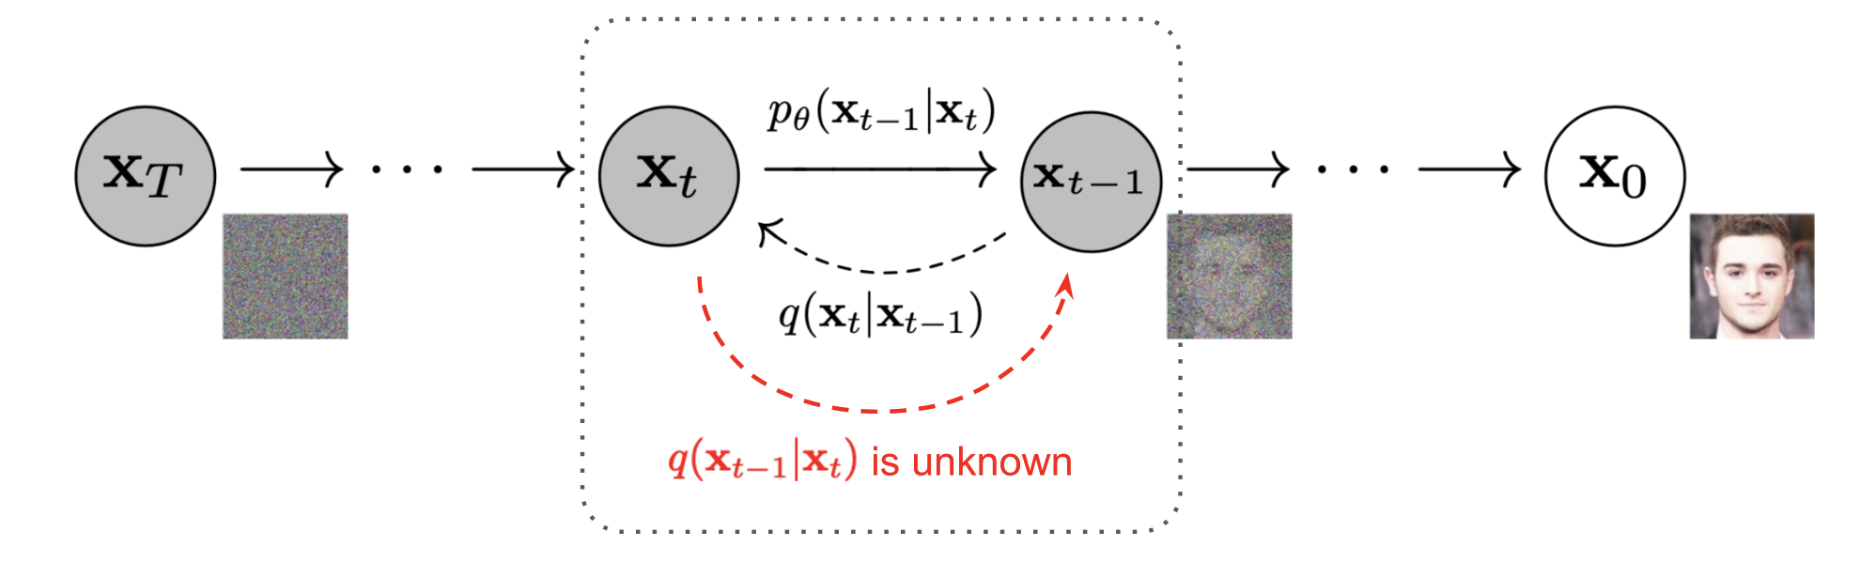

([Image Source](https://arxiv.org/abs/2006.11239))

Starting with a clean image, $x_0$, we can iteratively add noise to an image, obtaining progressively more and more noisy versions of the image, $x_t$, until we're left with basically pure noise at timestep $t=T$. When $t=0$, we have a clean image, and for larger $t$ more noise is in the image.

A diffusion model tries to reverse this process by denoising the image. By giving a diffusion model a noisy $x_t$ and the timestep $t$, the model predicts the noise in the image. With the predicted noise, we can either completely remove the noise from the image, to obtain an estimate of $x_0$, or we can remove just a portion of the noise, obtaining an estimate of $x_{t-1}$, with slightly less noise.

To generate images from the diffusion model (sampling), we start with pure noise at timestep $T$ sampled from a gaussian distribution, which we denote $x_T$. We can then predict and remove part of the noise, giving us $x_{T-1}$. Repeating this process until we arrive at $x_0$ gives us a clean image.

For the DeepFloyd models, $T = 1000$.

### Setup

The exact amount of noise added at each step is dictated by noise coefficients, $\bar\alpha_t$, which were chosen by the people who trained DeepFloyd. Run the cell below to create `alphas_cumprod`, which retrieves these coefficients. The number of coefficients is the same as the number of sampling steps.

In [10]:
# Get scheduler parameters
alphas_cumprod = stage_1.scheduler.alphas_cumprod
print(f"We have in total {alphas_cumprod.shape[0]} noise coefficients")

We have in total 1000 noise coefficients


We provide you our favorite Campanilie as a test image that you can work with!

Test image:


""

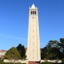

In [8]:
# Get test image
#!wget cal-cs180.github.io/fa24/hw/proj5/assets/campanile.jpg -O campanile.jpg
test_im = Image.open('/content/drive/MyDrive/campanile.jpg')

# For stage 1: Resize to (64, 64), convert to tensor, rescale to [-1, 1], and
# add a batch dimension. The result is a (1, 3, 64, 64) tensor
#test_im = Image.open('campanile.jpg')#.resize((64, 64))
test_im = TF.to_tensor(test_im)
test_im = 2 * test_im - 1
test_im = test_im[None]

# Show test image
print('Test image:')
media.show_image(test_im[0].permute(1,2,0) / 2. + 0.5)

# 1.1 Implementing the forward process

**Disclaimer about equations**: Colab sometimes cannot correctly render the math equations below. Please cross-reference them with the part A webpage to make sure that you're looking at the fully correct equation.

A key part of diffusion is the forward process, which takes a clean image and adds noise to it. In this part, we will write a function to implement this. The forward process is defined by:

$$ q(x_t | x_0) = N(x_t ; \sqrt{\bar\alpha_t} x_0, (1 - \bar\alpha_t)\mathbf{I})\tag{1}$$

which is equivalent to computing $$ x_t = \sqrt{\bar\alpha_t} x_0 + \sqrt{1 - \bar\alpha_t} \epsilon \quad \text{where}~ \epsilon \sim N(0, 1) \tag{2}$$

That is, given a clean image $x_0$, we get a noisy image $ x_t $ at timestep $t$ by sampling from a Gaussian with mean $ \sqrt{\bar\alpha_t} x_0 $ and variance $ (1 - \bar\alpha_t) $. Note that the forward process is not _just_ adding noise -- we also scale the image.

You will need to use the `alphas_cumprod` variable, which contains the $\bar\alpha_t$ for all $ t \in [0, 999] $. Remember that $t=0$ corresponds to a clean image, and larger $t$ corresponds to more noise. Thus, $\bar\alpha_t$ is close to 1 for small $t$, and close to 0 for large $t$. Run the forward process on the test image with $ t \in [250, 500, 750] $. Show the results -- you should get progressively more noisy images.

### Delivarables

- Implement the `im_noisy = forward(im, t)` function
- Show the Campanile at noise level [250, 500, 750]

### Hints

- The `torch.randn_like` function is helpful for computing $\epsilon$.
- Use the `alphas_cumprod` variable, which contains an array of the hyperparameters, with `alphas_cumprod[t]` corresponding to $\bar\alpha_t$.
- This is notebook, to show images, we recommend you to use `media.show_image` function. Documentation available [here](https://google.github.io/mediapy/mediapy.html).

In [40]:
def forward(im, t):
  """
  Args:
    im : torch tensor of size (1, 3, 64, 64) representing the clean image
    t : integer timestep

  Returns:
    im_noisy : torch tensor of size (1, 3, 64, 64) representing the noisy image at timestep t
  """
  with torch.no_grad():
    # ===== your code here! ====

    a_t = alphas_cumprod[t]
    a_t_sqrt = torch.sqrt(a_t)

    sqrt_one_minus_a_t = torch.sqrt(1 - a_t)

    epsilon = torch.randn_like(im)

    im_noisy = a_t_sqrt * im + sqrt_one_minus_a_t * epsilon

    # ===== end of code ====
  return im_noisy

""

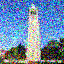

""

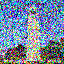

""

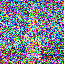

In [ ]:
# Show the test image at noise level [250, 500, 750]
# ===== your code here! ====

#im = Image.open("/content/drive/MyDrive/campanile.jpg")
#im = TF.to_tensor(test_im)


im250 = forward(test_im, 250)
im250 = im250[0].permute(1,2,0) / 2. + 0.5
media.show_image(im250)
media.write_image('/content/drive/MyDrive/campanile250.png', im250)

im500 = forward(test_im, 500)
im500 = im500[0].permute(1,2,0) / 2. + 0.5
media.show_image(im500)
media.write_image('/content/drive/MyDrive/campanile500.png', im500)

im750 = forward(test_im, 750)
im750 = im750[0].permute(1,2,0) / 2. + 0.5
media.show_image(im750)
media.write_image('/content/drive/MyDrive/campanile750.png', im750)
# ===== end of code ====

# 1.2 Classical Denoising

Let's try to denoise these images using classical methods. Again, take noisy images for timesteps [250, 500, 750], but use **Gaussian blur filtering** to try to remove the noise. Getting good results should be quite difficult, if not impossible.

### Deliverables

- For each of the 3 noisy Campanile images from the previous part, show your best Gaussian-denoised version side by side.

### Hint

- `torchvision.transforms.functional.gaussian_blur` is useful. Here is the [documentation](https://pytorch.org/vision/0.16/generated/torchvision.transforms.functional.gaussian_blur.html).

""

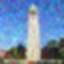

KeyboardInterrupt: 

In [ ]:
def denoise_gauss(im_path, t):

  im_pil = Image.open(im_path).convert('RGB') # Explicitly convert to RGB
  # Convert PIL image to a PyTorch tensor (C, H, W) with values [0, 1]
  im_tensor = TF.to_tensor(im_pil)

  # TF.gaussian_blur expects a tensor of shape (..., C, H, W) or (C, H, W).
  # We need to ensure it's in the correct range, typically [-1, 1] as used elsewhere,
  # and add a batch dimension for consistency with other parts of the notebook.

  # Denormalize from [0, 1] to [-1, 1] (as the output of forward is in [-1, 1])
  im_processed = im_tensor * 2 - 1
  # Add a batch dimension, making it (N, C, H, W)
  im_processed = im_processed[None]

  # Apply Gaussian blur
  im_blurred = TF.gaussian_blur(im_processed, kernel_size=(5, 5), sigma=(1.5, 1.5))

  # Prepare for display: remove batch dimension, permute to (H, W, C) and denormalize to [0, 1]
  display_image = im_blurred[0].permute(1,2,0) / 2. + 0.5
  media.show_image(display_image)
  media.write_image(f"/content/drive/MyDrive/campanile{t}_blurred.png", display_image)


im_path_250 = "/content/drive/MyDrive/campanile250.png"
denoise_gauss(im_path_250, 250)

im_path_500 = "/content/drive/MyDrive/campanile500.png"
denoise_gauss(im_path_500, 500)

im_path_750 = "/content/drive/MyDrive/campanile750.png"
denoise_gauss(im_path_750, 750)

# 1.3 Implementing One Step Denoising

Now, we'll use a pretrained diffusion model to denoise. The actual denoiser can be found at `stage_1.unet`. This is a UNet that has already been trained on a *very, very* large dataset of $(x_0, x_t)$ pairs of images. We can use it to recover Gaussian noise from the image. Then, we can remove this noise to recover (something close to) the original image. Note: this UNet is conditioned on the amount of Gaussian noise by taking timestep $t$ as additional input.



Because this diffusion model was trained with text conditioning, we also need a text prompt embedding. We provide the embedding for the prompt `"a high quality photo"` for you to use. Later on, you can use your own text prompts.

### Deliverables
For the 3 noisy images from 1.2 (t = [250, 500, 750]):
- Use your `forward` function to add noise to your Campanilie
- Estimate the noise in the new noisy image, by passing it through `stage_1.unet`
- Remove the noise from the noisy image to obtain an estimate of the original image
- Visualize the original image, the noisy image, and the estimate of the original image

### Hints
- When removing the noise, you can't simply subtract the noise estimate. Recall that in equation 2 we need to scale the noise. Look at equation 2 to figure out how we predict $x_0$ from $x_t$ and $t$.
- You will probably have to wrangle tensors to the correct device and into the correct data types. The functions `.to(device)` and `.half()` will be useful. The denoiser is loaded on the device `cuda` as `half` precision (to save memory), so inputs to the denoiser need to match them.
- The signature for the unet is `stage_1.unet(im_noisy, t, encoder_hidden_states=prompt_embeds, return_dict=False)`. You need to pass in the noisy image, the timestep, and the prompt embeddings. The `return_dict` argument just makes the output nicer.
- The unet will output a tensor of shape (1, 6, 64, 64). This is because DeepFloyd was trained to predict the noise as well as variance of the noise. The first 3 channels is the noise estimate, which you will use. The second 3 channels is the variance estimate which you may ignore for now.
- To save GPU memory, you should wrap all of your code in a `with torch.no_grad():` context. This tells torch not to do automatic differentiation, and saves a considerable amount of memory.

""

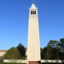

""

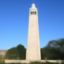

""

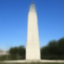

In [ ]:
# Please use the null prompt embedding
prompt_embeds = prompt_embeds_dict["a high quality photo"].to(device)

with torch.no_grad():
  for t in [250, 500, 750]:
    # Get alpha bar
    alpha_cumprod = alphas_cumprod[t]

    # Run forward process
    # ===== your code here! =====

    im_noisy = forward(test_im, t)

    # ==== end of code ====

    # Estimate noise in noisy image
    noise_est = stage_1.unet(
        im_noisy.half().cuda(),
        t,
        encoder_hidden_states=prompt_embeds,
        return_dict=False
    )[0]

    # Take only first 3 channels, and move result to cpu
    noise_est = noise_est[:, :3].cpu()

    # Remove the noise
    # run `.detach().numpy()` on the image so we can display it
    # ===== your code here! =====

    im_denoised = (im_noisy.cuda() - torch.sqrt(1 - alpha_cumprod)*noise_est.cuda()) / torch.sqrt(alpha_cumprod).cuda()
    im_denoised = im_denoised[0].permute(1,2,0).cpu() / 2. + 0.5

    media.show_image(im_denoised)

    media.write_image(f"/content/drive/MyDrive/campanile{t}_denoised.png", im_denoised)

    # ==== end of code ====

# 1.4 Implementing Iterative Denoising

In part 1.3, you should see that the denoising UNet does a much better job of projecting the image onto the natural image manifold, but it does get worse as you add more noise. This makes sense, as the problem is much harder with more noise!

But diffusion models are designed to denoise iteratively. In this part we will implement this.

In theory, we could start with noise $x_{1000}$ at timestep $T=1000$, denoise for one step to get an estimate of $x_{999}$, and carry on until we get $x_0$. But this would require running the diffusion model 1000 times, which is quite slow (and costs $$$).

It turns out, we can actually speed things up by skipping steps. The rationale for why this is possible is due to a connection with differential equations. It's a tad complicated, and out of scope for this course, but if you're interested you can check out [this excellent article](https://yang-song.net/blog/2021/score/).

To skip steps we can create a list of timesteps that we'll call `strided_timesteps`, which will be much shorter than the full list of 1000 timesteps. `strided_timesteps[0]` will correspond to the the largest $t$ (and thus the noisiest image) and `strided_timesteps[-1]` will correspond to $t = 0$ (and thus a clean image). One simple way of constructing this list is by introducing a regular stride step (e.g. stride of 30 works well).

On the `i`th denoising step we are at $ t = $ `strided_timesteps[i]`, and want to get to $ t' =$ `strided_timesteps[i+1]` (from more noisy to less noisy). To actually do this, we have the following formula:

$ x_{t'} = \frac{\sqrt{\bar\alpha_{t'}}\beta_t}{1 - \bar\alpha_t} x_0 + \frac{\sqrt{\alpha_t}(1 - \bar\alpha_{t'})}{1 - \bar\alpha_t} x_t + v_\sigma\tag{3}$

where:
- $x_t$ is your image at timestep $t$
- $x_{t'}$ is your noisy image at timestep $t'$ where $t' < t$ (less noisy)
- $\bar\alpha_t$ is defined by `alphas_cumprod`, as explained above.
- $\alpha_t = \bar\alpha_t / \bar\alpha_{t'}$
- $\beta_t = 1 - \alpha_t$
- $x_0$ is our current estimate of the clean image c (you can copy past from the previous section)

The $v_\sigma$ is random noise, which in the case of DeepFloyd is also predicted. The process to compute this is not very important for us, so we supply a function, `add_variance`, to do this for you.


You can think of this as a linear interpolation between the signal and noise:


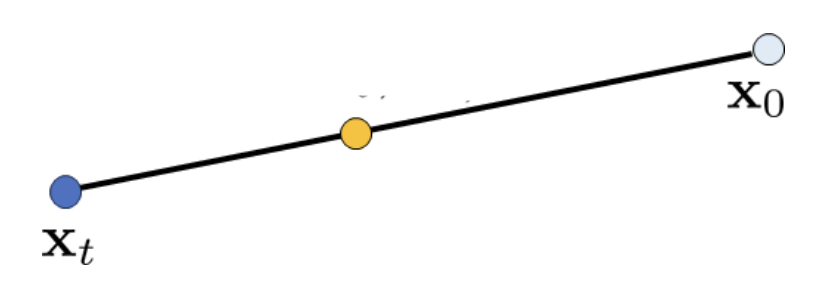

([Image Source](https://arxiv.org/abs/2403.18103))

For more information, see equations 6 and 7 of the [DDPM paper](https://arxiv.org/pdf/2006.11239) for more information (Denoising Diffusion Probabilistic Models, the paper that introduces the diffusion model, which comes from Cal!). Be careful about bars above the alpha! Some have them and some do not.

First create the list `strided_timesteps`. You should start at timestep 990, and take step sizes of size 30 until you arrive at 0. After completing the problem set, feel free to try different "schedules" of timesteps.

Also implement the function `iterative_denoise(im_noisy, i_start)`, which takes a noisy image `im_noisy`, as well as a starting index `i_start`. The function should denoise an image starting at timestep `timestep[i_start]`, applying the above formula to obtain an image at timestep `t' = timestep[i_start + 1]`, and repeat iteratively until we arrive at a clean image.

Add noise to the Campanilie test image to timestep `timestep[10]` and display this image. Then run the `iterative_denoise` function on the noisy image, with `i_start = 10`, to obtain a clean image and display it. Please display every 5th image of the denoising loop. Compare this to the "one-step" denoising method from the previous section, and to gaussian blurring.

### Deliverables
Using `i_start = 10`:
- Create `strided_timesteps`: a list of monotonically decreasing timesteps, starting at 990, with a stride of 30, eventually reaching 0. Also initialize the timesteps using the function `stage_1.scheduler.set_timesteps(timesteps=strided_timesteps)`
- Complete the `iterative_denoise` function
- Show the noisy Campanilie every 5th loop of denoising (it should gradually become less noisy)
- Show the final predicted clean image, using iterative denoising
- Show the predicted clean image using only a single denoising step, as was done in the previous part. This should look much worse.
- Show the predicted clean image using gaussian blurring, as was done in part 1.2.


### Hints

- Remember, the unet will output a tensor of shape (1, 6, 64, 64). This is because DeepFloyd was trained to predict the noise as well as variance of the noise. The first 3 channels is the noise estimate, which you will use here. The second 3 channels is the variance estimate which you will pass to the `add_variance` function
- Read the documentation for the `add_variance` function to figure out how to use it to add the $v_\sigma$ to the image.
- Depending on if your final images are torch tensors or numpy arrays, you may need to modify the `show_images` call a bit.

In [12]:
# Make timesteps. Must be list of ints satisfying:
# - monotonically decreasing
# - ends at 0
# - begins close to or at 999

# create `strided_timesteps`, a list of timesteps, from 990 to 0 in steps of 30
# ===== your code here! =====

strided_timesteps = [990 - i for i in range(0, 991, 30)]

# ==== end of code ====

stage_1.scheduler.set_timesteps(timesteps=strided_timesteps)    # Need this b/c variance computation

In [13]:
def add_variance(predicted_variance, t, image):
  '''
  Args:
    predicted_variance : (1, 3, 64, 64) tensor, last three channels of the UNet output
    t: scale tensor indicating timestep
    image : (1, 3, 64, 64) tensor, noisy image

  Returns:
    (1, 3, 64, 64) tensor, image with the correct amount of variance added
  '''
  # Add learned variance
  variance = stage_1.scheduler._get_variance(t, predicted_variance=predicted_variance)
  variance_noise = torch.randn_like(image)
  variance = torch.exp(0.5 * variance) * variance_noise
  return image + variance

In [14]:
def iterative_denoise(im_noisy, i_start, prompt_embeds, timesteps):
  image = im_noisy
  prompt_embeds = prompt_embeds.to(device) # Ensure prompt_embeds is on the correct device

  eps = 1e-5

  with torch.no_grad():
    for i in range(i_start, len(timesteps) - 1):
      # Get timesteps
      t = timesteps[i]
      prev_t = timesteps[i+1]

      # get `alpha_cumprod` and `alpha_cumprod_prev` for timestep t from `alphas_cumprod`
      # compute `alpha`
      # compute `beta`
      # ===== your code here! =====

      alpha_bar_t = alphas_cumprod[t].to(torch.float32).to(image.device)
      alpha_bar_prev_t = alphas_cumprod[prev_t].to(torch.float32).to(image.device)
      alpha = (alpha_bar_t / (alpha_bar_prev_t)).to(torch.float32).to(image.device)

      beta_t = 1.0 - alpha

      # ==== end of code ====

      # Get noise estimate
      model_output = stage_1.unet(
          image,
          t,
          encoder_hidden_states=prompt_embeds,
          return_dict=False
      )[0]

      # Split estimate into noise and variance estimate
      noise_est, predicted_variance = torch.split(model_output, image.shape[1], dim=1)

      # compute `pred_prev_image` (x_{t'}), the DDPM estimate for the image at the
      # next timestep, which is slightly less noisy. Use the equation 3.
      # This is the core of DDPM
      # ===== your code here! =====

      x0_est = (image - torch.sqrt(1 - alpha_bar_t) * noise_est) / torch.sqrt(alpha_bar_t + eps)
      #x0_est = torch.clamp(x0_est, -1.0, 1.0)

      denom = 1 - alpha_bar_t + eps
      term1 = ((torch.sqrt(alpha_bar_prev_t) * beta_t) / denom) * x0_est
      term2 = ((torch.sqrt(alpha) * (1 - alpha_bar_prev_t)) / denom) * image

      pred_prev_image = add_variance(predicted_variance, t, term1 + term2)

      if i % 5 == 0:
        im = pred_prev_image[0].permute(1,2,0) / 2. + 0.5
        im = im.cpu().detach().numpy()
        media.write_image(f'/content/drive/MyDrive/campanile_denoise{t}.png', im)

      # ==== end of code ====

      image = pred_prev_image

    clean = image.cpu().detach().numpy()

  return clean

# Please use this prompt embedding
prompt_embeds = prompt_embeds_dict["a high quality photo"].to(device)

# Add noise
i_start = 10
t = strided_timesteps[i_start]
im_noisy = forward(test_im, t).half().to(device)

# Denoise

clean = iterative_denoise(im_noisy,
                          i_start=i_start,
                          prompt_embeds=prompt_embeds,
                          timesteps=strided_timesteps)
clean = clean[0].transpose(1,2,0)
media.write_image('/content/drive/MyDrive/campanile_clean.png', clean)


# Compute the one step estimate of the clean image. Feel free to copy and paste
# code from part 1.3. Store the image into `clean_one_step`
# ===== your code here! =====

noise_est = stage_1.unet(
    im_noisy.half().cuda(),
    t,
    encoder_hidden_states=prompt_embeds,
    return_dict=False
)[0]

noise_est = noise_est[:, :3, :, :]

alpha_c = alphas_cumprod[t].to(torch.float32)
clean_one_step = (im_noisy.cuda() - torch.sqrt(1 - alpha_c)*noise_est.cuda()) / torch.sqrt(alpha_c)
#clean_one_step = clean_one_step[0].permute(1,2,0).cpu() / 2. + 0.5

clean_one_step = clean_one_step.cpu().detach().numpy()
clean_one_step = clean_one_step[0].transpose(1,2,0)
media.write_image('/content/drive/MyDrive/campanile_clean_one_step.png', clean_one_step)

# ==== end of code ====


# Compute the gaussian blurred noisy image, using kernel_size=5 and sigma=2.
# Feel free to copy code from part 1.2. Store the image as `blur_filtered`
# Show results
# ===== your code here! =====

blur_filtered = TF.gaussian_blur(im_noisy, kernel_size=(5, 5), sigma=(2, 2))

# Prepare for display: remove batch dimension, permute to (H, W, C) and denormalize to [0, 1]
blur_filtered = blur_filtered[0].permute(1,2,0) / 2. + 0.5

blur_filtered = blur_filtered.cpu().detach().numpy()

media.write_image('/content/drive/MyDrive/campanile_clean_blur.png', blur_filtered)

# ==== end of code ====

KeyError: 'a high quality photo'

# 1.5 Diffusion Model Sampling

In part 1.4, we use the diffusion model to denoise an image. Another thing we can do with the `iterative_denoise` function is to generate images from scratch. We can do this by setting `i_start = 0` and passing `im_noisy` as random noise. This effectively denoises pure noise. Please do this, and show 5 results of the prompt `"a high quality photo"`.

### Deliverables

- Show 5 sampled images

### Hints

- Use `torch.randn` to make the noise.
- Make sure you move the tensor to the correct device and correct data type by calling `.half()` and `.to(device)`.
- The quality of the images will not be spectacular, but should be reasonable images. We will fix this in the next section with CFG.

Step 690

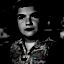

Step 690

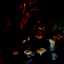

Step 690

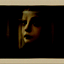

Step 690

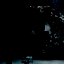

Step 690

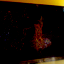

In [ ]:
# Please use this text prompt
prompt_embeds = prompt_embeds_dict["a high quality photo"]

strided_timesteps = [990 - i for i in range(0, 991, 30)]

for i in range(5):
  noise = torch.randn(1, 3, 64, 64).half().to(device)

  generated_image = iterative_denoise(noise, 0, prompt_embeds, strided_timesteps)
  generated_image = generated_image[0].transpose(1,2,0)
  media.show_image(generated_image, title=f'Step {t}')
  media.write_image(f'/content/drive/MyDrive/generated_image_{i}.png', generated_image)



# 1.6 Classifier Free Guidance

You may have noticed that some of the generated images in the prior section are not very good. In order to greatly improve image quality (at the expense of image diversity), we can use a technique called [Classifier-Free Guidance](https://arxiv.org/abs/2207.12598).

In CFG, we compute both a noise estimate conditioned on a text prompt, and an unconditional noise estimate. We denote these $\epsilon_c$ and $\epsilon_u$. Then, we let our new noise estimate be

$$\epsilon = \epsilon_u + \gamma (\epsilon_c - \epsilon_u) \tag{4}$$

where $\gamma$ controls the strength of CFG. Notice that for $\gamma=0$, we get an unconditional noise estimate, and for $\gamma=1$ we get the conditional noise estimate. The magic happens when $\gamma > 1$. In this case, we get much higher quality images. Why this happens is still up to vigorous debate. For more information on CFG, you can check out [this blog post](https://sander.ai/2022/05/26/guidance.html).

Please implement the `iterative_denoise_cfg` function, identical to the `iterative_denoise` function but using classifier-free guidance. To get an unconditional noise estimate, we can just pass an empty prompt embedding to the diffusion model (the model was trained to predict an unconditional noise estimate when given an empty text prompt).

### Disclaimer
Before, we used `"a high quality photo"` as a "null" condition. Now, we will use the actual `""` null prompt for unconditional guidance for CFG. In the later part, you should always use `""` null prompt for unconditional guidance.
### Deliverables

- Implement the `iterative_denoise_cfg` function
- Show 5 images with a prompt `"a high quality photo"` with a CFG scale of $\gamma=7$. Now this prompt becomes a **condition** (but fairly weak) to generate **conditional** noise! You will use your customized prompts as stronger conditions in part 1.7 - part 1.9.

### Hints

- You will need to run the UNet twice, once for the conditional prompt embedding, and once for the unconditional
- The UNet will predict both a conditional and an unconditional variance. Just use the conditional variance with the `add_variance` function.
- The resulting images should be much better than those in the prior section


In [43]:
# The conditional prompt embedding
#prompt_embeds = prompt_embeds_dict['a high quality photo'].to(device)

# The unconditional prompt embedding
#uncond_prompt_embeds = prompt_embeds_dict[''].to(device)


def iterative_denoise_cfg(im_noisy, i_start, prompt_embeds, uncond_prompt_embeds, timesteps, scale=7, display=True):
  image = im_noisy

  with torch.no_grad():
    for i in range(i_start, len(timesteps) - 1):
      # Get timesteps
      t = timesteps[i]
      prev_t = timesteps[i+1]

      # Get `alpha_cumprod`, `alpha_cumprod_prev`, `alpha`, `beta`
      # ===== your code here! =====

      alpha_bar_t = alphas_cumprod[t].to(torch.float32).to(image.device)
      alpha_bar_prev_t = alphas_cumprod[prev_t].to(torch.float32).to(image.device)
      alpha = (alpha_bar_t / (alpha_bar_prev_t)).to(torch.float32).to(image.device)

      beta_t = 1.0 - alpha

      # ==== end of code ====

      # Get cond noise estimate
      model_output = stage_1.unet(
          image,
          t,
          encoder_hidden_states=prompt_embeds,
          return_dict=False
      )[0]

      # Get uncond noise estimate
      uncond_model_output = stage_1.unet(
          image,
          t,
          encoder_hidden_states=uncond_prompt_embeds,
          return_dict=False
      )[0]

      # Split estimate into noise and variance estimate
      noise_est, predicted_variance = torch.split(model_output, image.shape[1], dim=1)
      uncond_noise_est, _ = torch.split(uncond_model_output, image.shape[1], dim=1)

      # Compute the CFG noise estimate based on equation 4
      # ===== your code here! =====

      noise_est = uncond_noise_est + scale * (noise_est - uncond_noise_est)

      # ==== end of code ====


      # Get `pred_prev_image`, the next less noisy image.
      # ===== your code here! =====

      x0_est = (image - torch.sqrt(1 - alpha_bar_t) * noise_est) / torch.sqrt(alpha_bar_t)
      #x0_est = torch.clamp(x0_est, -1.0, 1.0)

      denom = 1 - alpha_bar_t
      term1 = ((torch.sqrt(alpha_bar_prev_t) * beta_t) / denom) * x0_est
      term2 = ((torch.sqrt(alpha) * (1 - alpha_bar_prev_t)) / denom) * image

      pred_prev_image = add_variance(predicted_variance, t, term1 + term2)

      """
      if i % 5 == 0:
        im = pred_prev_image[0].permute(1,2,0) / 2. + 0.5
        im = im.cpu().detach().numpy()
        media.write_image(f'/content/drive/MyDrive/campanile_denoise{t}.png', im) """

      # ==== end of code ====

      image = pred_prev_image

    clean = image.cpu().detach().numpy()

  return clean

Step 690

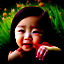

Step 690

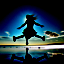

Step 690

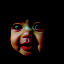

Step 690

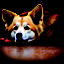

Step 690

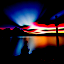

In [ ]:
strided_timesteps = [990 - i for i in range(0, 991, 30)]

for i in range(5):
  noise = torch.randn(1, 3, 64, 64).half().to(device)
  generated_image = iterative_denoise_cfg(noise, 0, prompt_embeds, uncond_prompt_embeds, strided_timesteps)
  generated_image = generated_image[0].transpose(1,2,0)
  media.show_image(generated_image, title=f'Step {t}')
  media.write_image(f'/content/drive/MyDrive/generated_image_cfg_{i}.png', generated_image)

# 1.7 Image-to-image Translation

In part 1.4, we take a real image, add noise to it, and then denoise. This effectively allows us to make edits to existing images. The more noise we add, the larger the edit will be. This works because in order to denoise an image, the diffusion model must to some extent "hallucinate" new things -- the model has to be "creative." Another way to think about it is that the denoising process "forces" a noisy image back onto the manifold of natural images.

Here, we're going to take the original Campanile image, noise it a little, and force it back onto the image manifold without any conditioning. Effectively, we're going to get an image that is similar to the Campanile (with a low-enough noise level). This follows the [SDEdit](https://sde-image-editing.github.io/) algorithm.

To start, please run the forward process to get a noisy Campanile, and then run the `iterative_denoise_cfg` function using a starting index of [1, 3, 5, 7, 10, 20] steps and show the results, labeled with the starting index. You should see a series of "edits" to the original image, gradually matching the original image closer and closer.

### Deliverables

- Edits of the Campanile image, using the given prompt at noise levels [1, 3, 5, 7, 10, 20] with the conditional text prompt `"a high quality photo"`
- Edits of 2 of your own test images, using the same procedure.

### Hints

- You should have a range of images, gradually looking more like the original image

Step 960

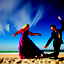

Step 900

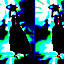

Step 840

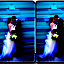

Step 780

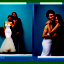

Step 690

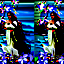

Step 390

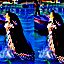

In [ ]:
# The conditional prompt embedding
import torch.nn.functional as F

prompt_embeds = prompt_embeds_dict['a high quality photo'].to(device)

# The unconditional prompt embedding
uncond_prompt_embeds = prompt_embeds_dict[''].to(device)

#test_im = test_im.to(device, dtype=torch.float16)


test_im = media.read_image("/content/drive/MyDrive/generated_image_stage3_10.png")
test_im = torch.from_numpy(test_im).permute(2, 0, 1).unsqueeze(0)


test_im = F.interpolate(
    test_im,
    size=(64, 64),
    mode="bilinear",
    align_corners=False,
)

test_im = (test_im / 255.0) * 2 - 1
test_im = test_im.to(device, dtype=torch.float16)


for i in [1, 3, 5, 7, 10, 20]:
    with torch.no_grad():
      t = strided_timesteps[i]
      im_noisy = forward(test_im, t)
      generated_image = iterative_denoise_cfg(im_noisy, i, prompt_embeds, uncond_prompt_embeds, strided_timesteps)
      generated_image = generated_image[0].transpose(1,2,0)
      media.show_image(generated_image, title=f'Step {t}')
      media.write_image(f'/content/drive/MyDrive/testim_edited1_{i}.png', generated_image)

## 1.7.1 Editing Hand-Drawn and Web Images

This procedure works particularly well if we start with a nonrealistic image (e.g. painting, a sketch, some scribbles) and project it onto the natural image manifold.

Please experiment by starting with hand-drawn or other non-realistic images and see how you can get them onto the natural image manifold in fun ways.

We provide you with 2 ways to provide inputs to the model:

1. download images from the web
2. draw your own images

Please find an image from the internet and apply edits exactly as above. And also draw your own images, and apply edits exactly as above. Feel free to copy the prior cell here. For drawing inspiration, you can check out the examples on [this project page](https://sde-image-editing.github.io/).

### Deliverables

- 1 image from the web of your choice, edited using the above method for noise levels [1, 3, 5, 7, 10, 20] (and whatever additional noise levels you want)
- 2 hand drawn images, edited using the above method for noise levels [1, 3, 5, 7, 10, 20] (and whatever additional noise levels you want)

### Hints
- We provide you with preprocessing code to convert web images to the format expected by DeepFloyd.
- Unfortunately, the drawing interface is hardcoded to be 300x600 pixels, but we need a square image. The code will center crop, so just draw in the middle of the canvas.

In [ ]:
# @title Function to Process Images

def process_pil_im(img):
  '''
  Transform a PIL image
  '''

  # Convert to RGB
  img = img.convert('RGB')

  # Define the transform to resize, convert to tensor, and normalize to [-1, 1]
  transform = transforms.Compose([
      transforms.Resize(64),               # Resize shortest side to 64
      transforms.CenterCrop(64),             # Center crop
      transforms.ToTensor(),               # Convert image to PyTorch tensor with range [0, 1]
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to range [-1, 1]
  ])

  # Apply the transformations and add batch dim
  img = transform(img)[None]

  # Show image
  print("Processed image")
  media.show_image(img[0].permute(1,2,0) / 2 + 0.5)

  return img

Processed image


""

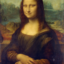

In [ ]:
# @title Download Images from Web

################
## CHANGE URL ##
################
#url = "https://upload.wikimedia.org/wikipedia/commons/6/6a/Mona_Lisa.jpg"
################
################

# Download image from URL and process
#response = requests.get(url)
#print(response.headers["Content-Type"])
#web_im = Image.open(BytesIO(response.content))
#web_im = process_pil_im(web_im)

web_im = Image.open("/content/drive/MyDrive/monalisa.jpg")

web_im = process_pil_im(web_im).to(device)

100%|██████████| 6/6 [00:25<00:00,  4.24s/it]


1,3,5,7,10,20

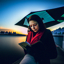
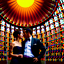
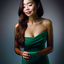
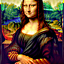
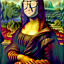
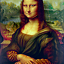

In [ ]:
prompt_embeds = prompt_embeds_dict["a high quality photo"].to(device)
uncond_prompt_embeds = prompt_embeds_dict[''].to(device)


imgs_dict = {}
for i_start in tqdm([1, 3, 5, 7, 10, 20]):
  # Add noise
  t = strided_timesteps[i_start]
  im_noisy = forward(web_im, t).half().to(device)

  # Denoise
  clean = iterative_denoise_cfg(im_noisy,
                                i_start=i_start,
                                prompt_embeds=prompt_embeds,
                                uncond_prompt_embeds=uncond_prompt_embeds,
                                timesteps=strided_timesteps,
                                display=False)

  # Add to dict to display later
  clean = clean[0].transpose(1,2,0) / 2. + 0.5
  imgs_dict[i_start] = clean
  media.write_image(f'/content/drive/MyDrive/web_edited_{i_start}.png', clean)

media.show_images(imgs_dict)


Processed image


""

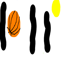

In [ ]:
# @title Hand Drawn Images

############
### N.B. ###
############

# This code is from: https://gist.github.com/karim23657/5ad5e067c1684dbc76c93bd88bf6fa53
# The board is hardcoded to be size 300 x 600, but we're using square images
# so please just draw in the center of the board
# In addition, this gist may be taken down or change location,
# which will break things in the future

############
############

from base64 import b64decode
from IPython.display import HTML
from google.colab.output import eval_js
import urllib.request
board_html = urllib.request.urlopen('https://gist.githubusercontent.com/karim23657/5ad5e067c1684dbc76c93bd88bf6fa53/raw/2ef57f881bc700c2c346bd6c7a7f2d5364b21048/drawing%2520board.html').read().decode('utf-8')

def draw(filename='drawing.png'):
  display(HTML(board_html))
  data = eval_js('triggerImageToServer')
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return Image.open(filename).convert('RGB')

drawn_im = draw('myImage.png').resize((64,64))

media.write_image('/content/drive/MyDrive/drawnimage.png', np.array(drawn_im))
drawn_im = process_pil_im(drawn_im)




100%|██████████| 6/6 [00:25<00:00,  4.25s/it]


1,3,5,7,10,20

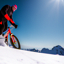
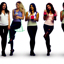
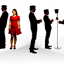
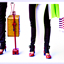
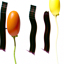
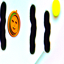

In [ ]:
prompt_embeds = prompt_embeds_dict["a high quality photo"].to(device)
uncond_prompt_embeds = prompt_embeds_dict[''].to(device)

imgs_dict = {}
for i_start in tqdm([1, 3, 5, 7, 10, 20]):
  # Add noise
  t = strided_timesteps[i_start]
  im_noisy = forward(drawn_im, t).half().to(device)

  # Denoise
  clean = iterative_denoise_cfg(im_noisy,
                                i_start=i_start,
                                prompt_embeds=prompt_embeds,
                                uncond_prompt_embeds=uncond_prompt_embeds,
                                timesteps=strided_timesteps,
                                display=False)

  # Add to dict to display later
  clean =clean[0].transpose(1,2,0) / 2. + 0.5
  media.write_image(f'/content/drive/MyDrive/drawnimage0_edited_{i_start}.png', clean)
  imgs_dict[i_start] = clean

media.show_images(imgs_dict)

# 1.7.2 Inpainting

We can use the same procedure to implement inpainting (following the [RePaint](https://arxiv.org/abs/2201.09865) paper). That is, given an image $x_{orig}$, and a binary mask $\bf m$, we can create a new image that has the same content where $\bf m$ is 0, but new content wherever $\bf m$ is 1.

To do this, we can run the diffusion denoising loop. But at every step, after obtaining $x_t$, we "force" $x_t$ to have the same pixels as $x_{orig}$ where $\bf m$ is 0, i.e.:

$ x_t \leftarrow \textbf{m} x_t + (1 - \textbf{m}) \text{forward}(x_{orig}, t) \tag{5}$

Essentially, we leave everything inside the edit mask alone, but we replace everything outside the edit mask with our original image -- with the correct amount of noise added for timestep $t$.

Please implement this below, and edit the picture to inpaint the top of the Campanile.

### Deliverables

- A properly implemented `inpaint` function
- The Campanile inpainted (feel free to use your own mask)
- 2 of your own images edited (come up with your own mask)
  - look at the results from [this paper](http://graphics.cs.cmu.edu/projects/scene-completion/) for inspiration

### Hints

- Reuse the `forward` function you implemented earlier
- Because we are using the diffusion model for tasks it was not trained for, you may have to run the sampling process a few times before you get a nice result.
- You can copy and paste from your `iterative_denoise_cfg` function. To get inpainting to work should only require (roughly) 1-2 additional lines and a few small changes.

Run the following cell to get the `mask` for inpainting:

In [ ]:
prompt_embeds = prompt_embeds_dict['a high quality photo'].to(device, dtype=torch.float16)

# The unconditional prompt embedding
uncond_prompt_embeds = prompt_embeds_dict[''].to(device, dtype=torch.float16)


def iterative_denoise_cfg_inpaint(im_noisy, i_start, prompt_embeds, uncond_prompt_embeds, timesteps, im_original, mask, scale=7):
  image = im_noisy
  image = image.to(device, dtype=torch.float16)
  mask = mask.to(device, dtype=torch.float16)
  im_original = im_original.to(device, dtype=torch.float16)

  with torch.no_grad():
    for i in range(i_start, len(timesteps) - 1):
      # Get timesteps
      t = timesteps[i]
      prev_t = timesteps[i+1]



      im_original_noisy = forward(im_original, t)
      image = mask * image + (1.0 - mask) * im_original_noisy

      # Get `alpha_cumprod`, `alpha_cumprod_prev`, `alpha`, `beta`

      # ===== your code here! =====

      alpha_bar_t = alphas_cumprod[t].to(torch.float32).to(image.device)
      alpha_bar_prev_t = alphas_cumprod[prev_t].to(torch.float32).to(image.device)
      alpha = (alpha_bar_t / (alpha_bar_prev_t)).to(torch.float32).to(image.device)

      beta_t = 1.0 - alpha

      # ==== end of code ====

      # Get cond noise estimate
      model_output = stage_1.unet(
          image,
          t,
          encoder_hidden_states=prompt_embeds,
          return_dict=False
      )[0]

      # Get uncond noise estimate
      uncond_model_output = stage_1.unet(
          image,
          t,
          encoder_hidden_states=uncond_prompt_embeds,
          return_dict=False
      )[0]

      # Split estimate into noise and variance estimate
      noise_est, predicted_variance = torch.split(model_output, image.shape[1], dim=1)
      uncond_noise_est, _ = torch.split(uncond_model_output, image.shape[1], dim=1)

      # Compute the CFG noise estimate based on equation 4
      # ===== your code here! =====

      noise_est = uncond_noise_est + scale * (noise_est - uncond_noise_est)

      # ==== end of code ====


      # Get `pred_prev_image`, the next less noisy image.
      # ===== your code here! =====

      x0_est = (image - torch.sqrt(1 - alpha_bar_t) * noise_est) / torch.sqrt(alpha_bar_t)
      #x0_est = torch.clamp(x0_est, -1.0, 1.0)

      denom = 1 - alpha_bar_t
      term1 = ((torch.sqrt(alpha_bar_prev_t) * beta_t) / denom) * x0_est
      term2 = ((torch.sqrt(alpha) * (1 - alpha_bar_prev_t)) / denom) * image

      pred_prev_image = add_variance(predicted_variance, t, term1 + term2)

      # ==== end of code ====

      image = pred_prev_image

    clean = image.cpu().detach().numpy()

  return clean

Image,Mask,To Replace

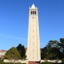
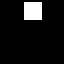
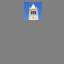

In [ ]:
# EDIT ME!
# Make mask
mask = torch.zeros_like(test_im)
mask[:, :, 2:20, 24:42] = 1.0
mask = mask.to(device)

# Visualize mask
media.show_images({
    'Image': test_im[0].permute(1,2,0) / 2. + 0.5,
    'Mask': mask.cpu()[0].permute(1,2,0),
    'To Replace': (test_im * mask.cpu())[0].permute(1,2,0) / 2. + 0.5,
})

Processed image


""

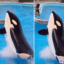

""

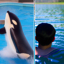

In [ ]:
def inpaint(original_image, mask, prompt_embeds, uncond_prompt_embeds, timesteps, scale=7, display=True):
  noise = torch.randn_like(original_image).to(device)

  # use your previous `iterative_denoise_cfg` function and make the appropriate changes
  t = strided_timesteps[0]

  image = iterative_denoise_cfg_inpaint(noise, 0, prompt_embeds, uncond_prompt_embeds, strided_timesteps, original_image, mask)

  return image

""" For campanile
inpainted_image = inpaint(test_im, mask, prompt_embeds, uncond_prompt_embeds, strided_timesteps)
inpainted_image = inpainted_image[0].transpose(1,2,0) / 2. + 0.5
media.show_image(inpainted_image)
media.write_image('/content/drive/MyDrive/inpainted_image.png', inpainted_image)
"""

im = Image.open("/content/drive/MyDrive/generated_image_stage3_10.png")
im = process_pil_im(im).to(device)
mask = torch.zeros_like(im)
mask[:, :, :64, 35:64] = 1.0
mask = mask.to(device)


inpainted_image = inpaint(im, mask, prompt_embeds, uncond_prompt_embeds, strided_timesteps)
inpainted_image = inpainted_image[0].transpose(1,2,0) / 2. + 0.5
media.show_image(inpainted_image)
media.write_image('/content/drive/MyDrive/inpainted_image2.png', inpainted_image)



# 1.7.3 Text-Conditioned Image-to-image Translation

Now, we will do the same thing as the previous section, but guide the projection with a text prompt. This is no longer pure "projection to the natural image manifold" but also adds control using language. This is simply a matter of changing the prompt from `"a high quality photo"` to any of your prompt!

### Deliverables

- Edits of the Campanile, using the given prompt at noise levels [1, 3, 5, 7, 10, 20]
- Edits of 2 of your own test images, using the same procedure.

### Hints

- The images should gradually look more like original image, but also look like the text prompt.

In [41]:
"""
prompt_embeds_dict2 = torch.load('/content/drive/MyDrive/prompt_embeds_dict.pth')

prompt_embeds = prompt_embeds_dict["a waterfall of blood"].to(device)
uncond_prompt_embeds = prompt_embeds_dict[''].to(device)

#im = Image.open("/content/drive/MyDrive/generated_image_stage3_10.png")
#im = process_pil_im(im).to(device)

mask = torch.zeros_like(test_im)
mask[:, :, 2:20, 24:42] = 1.0
mask = mask.to(device)


inpainted_image = inpaint(test_im, mask, prompt_embeds, uncond_prompt_embeds, strided_timesteps)
inpainted_image = inpainted_image[0].transpose(1,2,0) / 2. + 0.5
media.show_image(inpainted_image)
media.write_image('/content/drive/MyDrive/TCItIT01.png', inpainted_image)
"""
##################################################################################################

import torch.nn.functional as F

prompt_embeds_dict2 = torch.load('/content/drive/MyDrive/prompt_embeds_dict.pth')
prompt_embeds = prompt_embeds_dict2['a teacher teaching a class full of students'].to(device)

# The unconditional prompt embedding
uncond_prompt_embeds = prompt_embeds_dict2[''].to(device)



#test_im = media.read_image('/content/drive/MyDrive/campanile.jpg')

test_im = media.read_image("/content/drive/MyDrive/generated_image_stage3_2.png")
test_im = torch.from_numpy(test_im).permute(2, 0, 1).unsqueeze(0)


test_im = F.interpolate(
    test_im,
    size=(64, 64),
    mode="bilinear",
    align_corners=False,
)

test_im = (test_im / 255.0) * 2 - 1
test_im = test_im.to(device, dtype=torch.float16)


for i in [1, 3, 5, 7, 10, 20]:
    with torch.no_grad():
      t = strided_timesteps[i]
      im_noisy = forward(test_im, t)
      generated_image = iterative_denoise_cfg(im_noisy, i, prompt_embeds, uncond_prompt_embeds, strided_timesteps)
      generated_image = generated_image[0].transpose(1,2,0)
      media.show_image(generated_image, title=f'Step {t}')
      media.write_image(f'/content/drive/MyDrive/china_china{i}.png', generated_image)

NameError: name 'iterative_denoise_cfg' is not defined

## 1.8 Visual Anagrams

In this part, we are finally ready to implement [Visual Anagrams](https://dangeng.github.io/visual_anagrams/) and create optical illusions with diffusion models. In this part, we will create an image that looks like `"an oil painting of an old man"`, but when flipped upside down will reveal `"an oil painting of people around a campfire"`.

To do this, we will denoise an image $x_t$ at step $t$ normally with the prompt $p_1$, to obtain noise estimate $\epsilon_1$. But at the same time, we will flip $x_t$ upside down, and denoise with the prompt $p_2$, to get noise estimate $\epsilon_2$. We can flip $\epsilon_2$ back, and average the two noise estimates. We can then perform a reverse diffusion step with the averaged noise estimate.

The full algorithm is:

$ \epsilon_1 = \text{CFG of UNet}(x_t, t, p_1) $

$ \epsilon_2 = \text{flip}(\text{CFG of UNet}(\text{flip}(x_t), t, p_2))$

$ \epsilon = (\epsilon_1 + \epsilon_2) / 2 $

where UNet is the diffusion model UNet from before, $\text{flip}(\cdot)$ is a function that flips the image, and $p_1$ and $p_2$ are two different text prompt embeddings. And our final noise estimate is $\epsilon$. Please implement the above algorithm and show example of an illusion.

### Deliverables

- Correctly implemented `visual_anagrams` function
- 2 illusions of your choice that change appearance when you flip it upside down

### Hints

- You may have to run multiple times to get a really good result for the same reasons as above

In [42]:

def iterative_denoise_cfg_va(im_noisy, i_start, prompt_embeds, prompt_embeds2, uncond_prompt_embeds, timesteps, scale=7):
  image = im_noisy
  image = image.to(device, dtype=torch.float16)

  with torch.no_grad():
    for i in range(i_start, len(timesteps) - 1):
      # Get un
      t = timesteps[i]
      prev_t = timesteps[i+1]

      # Get `alpha_cumprod`, `alpha_cumprod_prev`, `alpha`, `beta`
      # ===== your code here! =====

      alpha_bar_t = alphas_cumprod[t].to(torch.float32).to(image.device)
      alpha_bar_prev_t = alphas_cumprod[prev_t].to(torch.float32).to(image.device)
      alpha = (alpha_bar_t / (alpha_bar_prev_t)).to(torch.float32).to(image.device)

      beta_t = 1.0 - alpha

      # ==== end of code ====

      # Get cond noise estimate
      model_output = stage_1.unet(
          image,
          t,
          encoder_hidden_states=prompt_embeds,
          return_dict=False
      )[0]

      # Get uncond noise estimate
      uncond_model_output = stage_1.unet(
          image,
          t,
          encoder_hidden_states=uncond_prompt_embeds,
          return_dict=False
      )[0]

      # Split estimate into noise and variance estimate
      noise_est1, predicted_variance = torch.split(model_output, image.shape[1], dim=1)
      uncond_noise_est1, _ = torch.split(uncond_model_output, image.shape[1], dim=1)

      noise_est1 = uncond_noise_est1 + scale * (noise_est1 - uncond_noise_est1)

      image_flipped = torch.flip(image, dims=[2])

      model_output2 = stage_1.unet(
          image_flipped,
          t,
          encoder_hidden_states=prompt_embeds2,
          return_dict=False
      )[0]

      uncond_model_output2 = stage_1.unet(
          image_flipped,
          t,
          encoder_hidden_states=uncond_prompt_embeds,
          return_dict=False
      )[0]

      noise_est2, predicted_variance2 = torch.split(model_output2, image_flipped.shape[1], dim=1)
      uncond_noise_est2, _ = torch.split(uncond_model_output2, image_flipped.shape[1], dim=1)

      noise_est2 = uncond_noise_est2 + scale * (noise_est2 - uncond_noise_est2)
      noise_est2 = torch.flip(noise_est2, dims=[2])

      noise_est = 0.5 * (noise_est1 + noise_est2)
      #noise_est = 0.3 * noise_est1 + 0.7 * noise_est2

      # Get `pred_prev_image`, the next less noisy image.
      # ===== your code here! =====

      x0_est = (image - torch.sqrt(1 - alpha_bar_t) * noise_est) / torch.sqrt(alpha_bar_t)
      #x0_est = torch.clamp(x0_est, -1.0, 1.0)

      denom = 1 - alpha_bar_t
      term1 = ((torch.sqrt(alpha_bar_prev_t) * beta_t) / denom) * x0_est
      term2 = ((torch.sqrt(alpha) * (1 - alpha_bar_prev_t)) / denom) * image

      pred_prev_image = add_variance(predicted_variance, t, term1 + term2)

      # ==== end of code ====

      image = pred_prev_image

    clean = image.cpu().detach().numpy()

  return clean

""

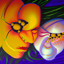

In [ ]:
def make_flip_illusion(image, i_start, prompt_embeds, prompt_embeds2, uncond_prompt_embeds, timesteps, scale=7, display=True):
  noise = torch.randn_like(image).to(device)

  # use your previous `iterative_denoise_cfg` function and make the appropriate changes
  t = strided_timesteps[0]

  image = iterative_denoise_cfg_va(noise, 0, prompt_embeds, prompt_embeds2, uncond_prompt_embeds, strided_timesteps)

  return image

#im = Image.open("/content/drive/MyDrive/generated_image_stage3_10.png")
#im = process_pil_im(im).to(device)

prompt_embeds = prompt_embeds_dict["an oil painting of two faces almost touching"].to(device)
prompt_embeds2 = prompt_embeds_dict["an oil painting of two blooming flowers"].to(device)
uncond_prompt_embeds = prompt_embeds_dict[''].to(device)

illusion = make_flip_illusion(test_im, 0, prompt_embeds, prompt_embeds2, uncond_prompt_embeds, strided_timesteps)
illusion = illusion[0].transpose(1,2,0) / 2. + 0.5
media.show_image(illusion)
media.write_image('/content/drive/MyDrive/illusion.png', illusion)

## 1.9 Hybrid Images

In this part we'll implement [Factorized Diffusion](https://dangeng.github.io/factorized_diffusion/) and create hybrid images just like in project 2.

In order to create hybrid images with a diffusion model we can use a similar technique as above. We will create a composite noise estimate $\epsilon$, by estimating the noise with two different text prompts, and then combining low frequencies from one noise estimate with high frequencies of the other. The algorithm is:

$ \epsilon_1 = \text{CFG of UNet}(x_t, t, p_1) $

$ \epsilon_2 = \text{CFG of UNet}(x_t, t, p_2) $

$ \epsilon = f_\text{lowpass}(\epsilon_1) + f_\text{highpass}(\epsilon_2)$

where UNet is the diffusion model UNet, $f_\text{lowpass}$ is a low pass function, $f_\text{highpass}$ is a high pass function, and $p_1$ and $p_2$ are two different text prompt embeddings. Our final noise estimate is $\epsilon$. Please show an example of a hybrid image using this technique (you may have to run multiple times to get a really good result for the same reasons as above). We recommend that you use a gaussian blur of kernel size 33 and sigma 2.

### Deliverables

- Correctly implemented `make_hybrids` function
- 2 hybrid images of your choice

### Hints

- Please use `torchvision.transforms.functional.gaussian_blur`. Here is the [documentation](https://pytorch.org/vision/0.16/generated/torchvision.transforms.functional.gaussian_blur.html).
- You may have to run multiple times to get a really good result for the same reasons as above

Run the following cell to get the correct prompt embeddings:

In [ ]:
import torchvision
def iterative_denoise_cfg_hybrid_ims(im_noisy, i_start, prompt_embeds, prompt_embeds2, uncond_prompt_embeds, timesteps, scale=4):
  image = im_noisy
  image = image.to(device, dtype=torch.float16)

  with torch.no_grad():
    for i in range(i_start, len(timesteps) - 1):
      # Get un
      t = timesteps[i]
      prev_t = timesteps[i+1]

      # Get `alpha_cumprod`, `alpha_cumprod_prev`, `alpha`, `beta`
      # ===== your code here! =====

      alpha_bar_t = alphas_cumprod[t].to(torch.float32).to(image.device)
      alpha_bar_prev_t = alphas_cumprod[prev_t].to(torch.float32).to(image.device)
      alpha = (alpha_bar_t / (alpha_bar_prev_t)).to(torch.float32).to(image.device)

      beta_t = 1.0 - alpha

      # ==== end of code ====

      # Get cond noise estimate
      model_output = stage_1.unet(
          image,
          t,
          encoder_hidden_states=prompt_embeds,
          return_dict=False
      )[0]

      # Get uncond noise estimate
      uncond_model_output = stage_1.unet(
          image,
          t,
          encoder_hidden_states=uncond_prompt_embeds,
          return_dict=False
      )[0]

      # Split estimate into noise and variance estimate
      noise_est1, predicted_variance = torch.split(model_output, image.shape[1], dim=1)
      uncond_noise_est1, _ = torch.split(uncond_model_output, image.shape[1], dim=1)

      noise_est1 = uncond_noise_est1 + scale * (noise_est1 - uncond_noise_est1)

      model_output2 = stage_1.unet(
          image,
          t,
          encoder_hidden_states=prompt_embeds2,
          return_dict=False
      )[0]

      uncond_model_output2 = stage_1.unet(
          image,
          t,
          encoder_hidden_states=uncond_prompt_embeds,
          return_dict=False
      )[0]

      noise_est2, predicted_variance2 = torch.split(model_output2, image.shape[1], dim=1)
      uncond_noise_est2, _ = torch.split(uncond_model_output2, image.shape[1], dim=1)

      noise_est2 = uncond_noise_est2 + scale * (noise_est2 - uncond_noise_est2)

      eps1_low = torchvision.transforms.functional.gaussian_blur(noise_est1, kernel_size=33, sigma=2)

      eps2_low = torchvision.transforms.functional.gaussian_blur(noise_est2, kernel_size=33, sigma=2)
      eps2_high = noise_est2 - eps2_low

      noise_est = eps1_low + eps2_high


      # Get `pred_prev_image`, the next less noisy image.
      # ===== your code here! =====

      x0_est = (image - torch.sqrt(1 - alpha_bar_t) * noise_est) / torch.sqrt(alpha_bar_t)
      #x0_est = torch.clamp(x0_est, -1.0, 1.0)

      denom = 1 - alpha_bar_t
      term1 = ((torch.sqrt(alpha_bar_prev_t) * beta_t) / denom) * x0_est
      term2 = ((torch.sqrt(alpha) * (1 - alpha_bar_prev_t)) / denom) * image

      pred_prev_image = add_variance(predicted_variance, t, term1 + term2)

      # ==== end of code ====

      image = pred_prev_image

    clean = image.cpu().detach().numpy()

  return clean

In [ ]:
prompt_embeds_dict = torch.load('/content/drive/MyDrive/prompt_embeds_dict.pth')

""

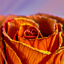

In [ ]:

def make_hybrids(image, i_start, prompt_embeds, prompt_embeds2, uncond_prompt_embeds, timesteps, scale=7, display=True):
  noise = torch.randn_like(image).to(device)

  # use your previous `iterative_denoise_cfg` function and make the appropriate changes
  t = strided_timesteps[0]

  image = iterative_denoise_cfg_hybrid_ims(noise, 0, prompt_embeds, prompt_embeds2, uncond_prompt_embeds, timesteps)

  return image

#im = Image.open("/content/drive/MyDrive/generated_image_stage3_10.png")
#im = process_pil_im(im).to(device)

prompt_embeds = prompt_embeds_dict["a canyon scene with large red and orange cliffs, deep shadows, smooth rocks, and broad shapes"].to(device)
prompt_embeds2 = prompt_embeds_dict["close-up of dried rose petals with sharp micro-details, deep wrinkles"].to(device)
uncond_prompt_embeds = prompt_embeds_dict[''].to(device)

hybrid_image = make_hybrids(test_im, 0, prompt_embeds, prompt_embeds2, uncond_prompt_embeds, strided_timesteps)
hybrid_image = hybrid_image[0].transpose(1,2,0) / 2. + 0.5
media.show_image(hybrid_image)
media.write_image('/content/drive/MyDrive/hybrid_image4.png', hybrid_image)

# Part 2: Bells & Whistles

**Required for CS280A students only:**

- **More visual anagrams!** Visual anagrams in part 1.8 are created by flipping images upside down. However, there are much more transformations that also create visual anagrams! Refer to this [paper](https://arxiv.org/pdf/2311.17919) and select two more transformations to create visual anagrams.
- **Design a course logo**! Doing text-conditioned image-to-image translation on UCB's logo or your drawing may be a good idea.

**Optional for all students:**

- **Your own ideas**: Be creative!

""

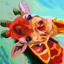

In [25]:
def iterative_denoise_cfg_4flips(im_noisy, i_start, prompt_embeds, prompt_embeds2, prompt_embeds3, prompt_embeds4, uncond_prompt_embeds, timesteps, scale=7):
  image = im_noisy
  image = image.to(device, dtype=torch.float16)

  with torch.no_grad():
    for i in range(i_start, len(timesteps) - 1):
      # Get un
      t = timesteps[i]
      prev_t = timesteps[i+1]

      # Get `alpha_cumprod`, `alpha_cumprod_prev`, `alpha`, `beta`
      # ===== your code here! =====

      alpha_bar_t = alphas_cumprod[t].to(torch.float32).to(image.device)
      alpha_bar_prev_t = alphas_cumprod[prev_t].to(torch.float32).to(image.device)
      alpha = (alpha_bar_t / (alpha_bar_prev_t)).to(torch.float32).to(image.device)

      beta_t = 1.0 - alpha

      # ==== end of code ====

      # Get cond noise estimate
      model_output = stage_1.unet(
          image,
          t,
          encoder_hidden_states=prompt_embeds,
          return_dict=False
      )[0]

      # Get uncond noise estimate
      uncond_model_output = stage_1.unet(
          image,
          t,
          encoder_hidden_states=uncond_prompt_embeds,
          return_dict=False
      )[0]

      # Split estimate into noise and variance estimate
      noise_est1, predicted_variance = torch.split(model_output, image.shape[1], dim=1)
      uncond_noise_est1, _ = torch.split(uncond_model_output, image.shape[1], dim=1)

      noise_est1 = uncond_noise_est1 + scale * (noise_est1 - uncond_noise_est1)


      image_90 = torch.rot90(image, k=1, dims=[2, 3])
      model_output2 = stage_1.unet(
          image_90,
          t,
          encoder_hidden_states=prompt_embeds2,
          return_dict=False
      )[0]

      uncond_model_output2 = stage_1.unet(
          image_90,
          t,
          encoder_hidden_states=uncond_prompt_embeds,
          return_dict=False
      )[0]

      noise_est2, predicted_variance2 = torch.split(model_output2, image_90.shape[1], dim=1)
      uncond_noise_est2, _ = torch.split(uncond_model_output2, image_90.shape[1], dim=1)

      noise_est2 = uncond_noise_est2 + scale * (noise_est2 - uncond_noise_est2)
      noise_est2 = torch.rot90(noise_est2, k=3,dims=[2,3]) # key value should rotate it back

      ############# 3 ######################

      image_180 = torch.rot90(image, k=2, dims=[2,3])
      model_output3 = stage_1.unet(
          image_180,
          t,
          encoder_hidden_states=prompt_embeds3,
          return_dict=False
      )[0]

      uncond_model_output3 = stage_1.unet(
          image_180,
          t,
          encoder_hidden_states=uncond_prompt_embeds,
          return_dict=False
      )[0]

      noise_est3, _ = torch.split(model_output3, image_180.shape[1], dim=1)
      uncond_noise_est3, _ = torch.split(uncond_model_output3, image_180.shape[1], dim=1)

      noise_est3 = uncond_noise_est3 + scale * (noise_est3 - uncond_noise_est3)
      noise_est3 = torch.rot90(noise_est3, k=2, dims=[2,3])

      ################### 4 ################

      image_270 = torch.rot90(image, k=3, dims=[2, 3])
      model_output4 = stage_1.unet(
          image_270,
          t,
          encoder_hidden_states=prompt_embeds4,
          return_dict=False
      )[0]

      uncond_model_output4 = stage_1.unet(
          image_270,
          t,
          encoder_hidden_states=uncond_prompt_embeds,
          return_dict=False
      )[0]

      noise_est4, _ = torch.split(model_output4, image_270.shape[1], dim=1)
      uncond_noise_est4, _ = torch.split(uncond_model_output4, image_270.shape[1], dim=1)

      noise_est4 = uncond_noise_est4 + scale * (noise_est4 - uncond_noise_est4)
      noise_est4 = torch.rot90(noise_est4, k=1, dims=[2,3])

      #######################################

      noise_est = 0.25 * (noise_est1 + noise_est2 + noise_est3 + noise_est4)
      #noise_est = 0.3 * noise_est1 + 0.7 * noise_est2

      # Get `pred_prev_image`, the next less noisy image.
      # ===== your code here! =====

      x0_est = (image - torch.sqrt(1 - alpha_bar_t) * noise_est) / torch.sqrt(alpha_bar_t)
      #x0_est = torch.clamp(x0_est, -1.0, 1.0)

      denom = 1 - alpha_bar_t
      term1 = ((torch.sqrt(alpha_bar_prev_t) * beta_t) / denom) * x0_est
      term2 = ((torch.sqrt(alpha) * (1 - alpha_bar_prev_t)) / denom) * image

      pred_prev_image = add_variance(predicted_variance, t, term1 + term2)

      # ==== end of code ====

      image = pred_prev_image

    clean = image.cpu().detach().numpy()

  return clean

def make_illusion_4flips(image, i_start, prompt_embeds, prompt_embeds2, prompt_embeds3, prompt_embeds4, uncond_prompt_embeds, timesteps, scale=7, display=True):
  noise = torch.randn_like(image).to(device)

  # use your previous `iterative_denoise_cfg` function and make the appropriate changes
  t = strided_timesteps[0]

  image = iterative_denoise_cfg_4flips(noise, 0, prompt_embeds, prompt_embeds2, prompt_embeds3, prompt_embeds4, uncond_prompt_embeds, strided_timesteps)

  return image

prompt_embeds_dict = torch.load('/content/drive/MyDrive/prompt_embeds_dict3.pth')

prompt_embeds = prompt_embeds_dict["an oil painting of beautiful flowers"].to(device)
prompt_embeds2 = prompt_embeds_dict["an oil painting of a dog"].to(device)
prompt_embeds3 = prompt_embeds_dict["an oil painting of woman's face"].to(device)
prompt_embeds4 = prompt_embeds_dict["an oil painting of a giraffe"].to(device)
uncond_prompt_embeds = prompt_embeds_dict[''].to(device)

illusion = make_illusion_4flips(test_im, 0, prompt_embeds, prompt_embeds2, prompt_embeds3, prompt_embeds4, uncond_prompt_embeds, strided_timesteps)
illusion = illusion[0].transpose(1,2,0) / 2. + 0.5
media.show_image(illusion)
media.write_image('/content/drive/MyDrive/illusion_4flips3.png', illusion)

In [37]:
def iterative_denoise_cfg_negatives(im_noisy, i_start, prompt_embeds, prompt_embeds2, uncond_prompt_embeds, timesteps, scale=7):
  image = im_noisy
  image = image.to(device, dtype=torch.float16)

  with torch.no_grad():
    for i in range(i_start, len(timesteps) - 1):
      # Get un
      t = timesteps[i]
      prev_t = timesteps[i+1]

      # Get `alpha_cumprod`, `alpha_cumprod_prev`, `alpha`, `beta`
      # ===== your code here! =====

      alpha_bar_t = alphas_cumprod[t].to(torch.float32).to(image.device)
      alpha_bar_prev_t = alphas_cumprod[prev_t].to(torch.float32).to(image.device)
      alpha = (alpha_bar_t / (alpha_bar_prev_t)).to(torch.float32).to(image.device)

      beta_t = 1.0 - alpha

      # ==== end of code ====

      # Get cond noise estimate
      model_output = stage_1.unet(
          image,
          t,
          encoder_hidden_states=prompt_embeds,
          return_dict=False
      )[0]

      # Get uncond noise estimate
      uncond_model_output = stage_1.unet(
          image,
          t,
          encoder_hidden_states=uncond_prompt_embeds,
          return_dict=False
      )[0]

      # Split estimate into noise and variance estimate
      noise_est1, predicted_variance = torch.split(model_output, image.shape[1], dim=1)
      uncond_noise_est1, _ = torch.split(uncond_model_output, image.shape[1], dim=1)

      noise_est1 = uncond_noise_est1 + scale * (noise_est1 - uncond_noise_est1)

  #####################################################

      image_neg = -image
      model_output2 = stage_1.unet(
          image_neg,
          t,
          encoder_hidden_states=prompt_embeds2,
          return_dict=False
      )[0]

      uncond_model_output2 = stage_1.unet(
          image_neg,
          t,
          encoder_hidden_states=uncond_prompt_embeds,
          return_dict=False
      )[0]

      noise_est2, predicted_variance2 = torch.split(model_output2, image_neg.shape[1], dim=1)
      uncond_noise_est2, _ = torch.split(uncond_model_output2, image_neg.shape[1], dim=1)

      noise_est2 = uncond_noise_est2 + scale * (noise_est2 - uncond_noise_est2)
      noise_est2 = -noise_est2

      #######################################

      noise_est = 0.5 * (noise_est1 + noise_est2)
      #noise_est = 0.3 * noise_est1 + 0.7 * noise_est2

      # Get `pred_prev_image`, the next less noisy image.
      # ===== your code here! =====

      x0_est = (image - torch.sqrt(1 - alpha_bar_t) * noise_est) / torch.sqrt(alpha_bar_t)
      #x0_est = torch.clamp(x0_est, -1.0, 1.0)

      denom = 1 - alpha_bar_t
      term1 = ((torch.sqrt(alpha_bar_prev_t) * beta_t) / denom) * x0_est
      term2 = ((torch.sqrt(alpha) * (1 - alpha_bar_prev_t)) / denom) * image

      pred_prev_image = add_variance(predicted_variance, t, term1 + term2)

      # ==== end of code ====

      image = pred_prev_image

    clean = image.cpu().detach().numpy()

  return clean

def make_illusion_negatives(image, i_start, prompt_embeds, prompt_embeds2, uncond_prompt_embeds, timesteps, scale=7, display=True):
  noise = torch.randn_like(image).to(device)

  # use your previous `iterative_denoise_cfg` function and make the appropriate changes
  t = strided_timesteps[0]

  image = iterative_denoise_cfg_negatives(noise, 0, prompt_embeds, prompt_embeds2, uncond_prompt_embeds, strided_timesteps)

  return image

prompt_embeds_dict = torch.load('/content/drive/MyDrive/prompt_embeds_dict3.pth')

prompt_embeds = prompt_embeds_dict["an oil painting of beautiful flowers"].to(device)
prompt_embeds2 = prompt_embeds_dict["an oil painting of a dog"].to(device)
prompt_embeds3 = prompt_embeds_dict["an oil painting of woman's face"].to(device)
prompt_embeds4 = prompt_embeds_dict["an oil painting of a giraffe"].to(device)
uncond_prompt_embeds = prompt_embeds_dict[''].to(device)

illusion = make_illusion_negatives(test_im, 0, prompt_embeds2, prompt_embeds2, uncond_prompt_embeds, strided_timesteps)
illusion = illusion[0].transpose(1,2,0) / 2. + 0.5

#media.show_image(illusion)

illusion = illusion.clip(0,1)
neg = 1.0 - illusion

media.show_image(illusion)
media.show_image(neg)

media.write_image('/content/drive/MyDrive/illusion_neg6.png', illusion)
media.write_image('/content/drive/MyDrive/illusion_neg7.png', neg)

KeyboardInterrupt: 

Step 960

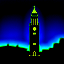

Step 900

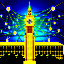

Step 840

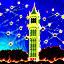

Step 780

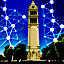

Step 690

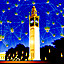

Step 390

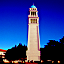

In [50]:
import torch.nn.functional as F

prompt_embeds_dict2 = torch.load('/content/drive/MyDrive/prompt_embeds_dict12.pth')
prompt_embeds = prompt_embeds_dict2['the Berkeley Campanile drawn as a neural network graph, glowing connections, blue and gold nodes, futuristic look'].to(device)

# The unconditional prompt embedding
uncond_prompt_embeds = prompt_embeds_dict2[''].to(device)



test_im = media.read_image('/content/drive/MyDrive/campanile.jpg')

#test_im = media.read_image("/content/drive/MyDrive/ucb_logo.png")
test_im = torch.from_numpy(test_im).permute(2, 0, 1).unsqueeze(0)


test_im = F.interpolate(
    test_im,
    size=(64, 64),
    mode="bilinear",
    align_corners=False,
)

test_im = (test_im / 255.0) * 2 - 1
test_im = test_im.to(device, dtype=torch.float16)


for i in [1, 3, 5, 7, 10, 20]:
    with torch.no_grad():
      t = strided_timesteps[i]
      im_noisy = forward(test_im, t)
      generated_image = iterative_denoise_cfg(im_noisy, i, prompt_embeds, uncond_prompt_embeds, strided_timesteps)
      generated_image = generated_image[0].transpose(1,2,0)
      media.show_image(generated_image, title=f'Step {t}')
      media.write_image(f'/content/drive/MyDrive/class_logo{i}_.png', generated_image)

# [Optional] Upsampling Images

If you want to upsample your $64\times 64$ images to $256 \times 256$, you can use the following code:

In [ ]:
def upsample(image64, prompt_embeds):
  """
  Args:
    image64 : torch tensor of size (1, 3, 64, 64) representing the image
    prompt_embeds : torch tensor of size (1, 77, 4096), prompt embedding

  Returns:
    image256 : torch tensor of size (1, 3, 256, 256), upsampled image
  """

  image256 = stage_2(
      image=image64,
      num_inference_steps=30,
      prompt_embeds=prompt_embeds,
      negative_prompt_embeds=prompt_embeds_dict[''],
      output_type="pt",
  ).images.cpu()

  return image256

hybrid_256 = upsample(torch.tensor(clean),
                      prompt_embeds[:1])
media.show_images(
    {
        'hybrid': hybrid_256[0].permute(1,2,0) / 2. + 0.5,
    }
)